## Applying Clustering to extract true-healthy from ai-readi-healthy group

In [4]:
pilot_data_root = "C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset/"  # change this to your own path

# manifest.tsv
manifest_path = pilot_data_root + "/wearable_blood_glucose/manifest.tsv"
print(manifest_path)

C:/Users/nikhi/Box/AI-READI/nikhil working dataset/dataset//wearable_blood_glucose/manifest.tsv


In [6]:
import pandas as pd
dfm = pd.read_csv(manifest_path, sep='\t')
print(dfm.columns)

Index(['participant_id', 'glucose_filepath', 'glucose_level_record_count',
       'average_glucose_level_mg_dl', 'glucose_sensor_sampling_duration_days',
       'glucose_sensor_id', 'manufacturer', 'manufacturer_model_name'],
      dtype='object')


0.053 --> 0.041 --> 0.041 --> 0.040 --> 0.040 --> 0.040 --> 
Cluster labels: {np.int64(1006): np.int64(3), np.int64(1021): np.int64(3), np.int64(1030): np.int64(3), np.int64(1033): np.int64(0), np.int64(1037): np.int64(1), np.int64(1043): np.int64(2), np.int64(1048): np.int64(2), np.int64(1050): np.int64(0), np.int64(1051): np.int64(0), np.int64(1053): np.int64(3), np.int64(1054): np.int64(2), np.int64(1055): np.int64(3), np.int64(1057): np.int64(0), np.int64(1060): np.int64(3), np.int64(1065): np.int64(3), np.int64(1069): np.int64(0), np.int64(1074): np.int64(3), np.int64(1079): np.int64(1), np.int64(1084): np.int64(2), np.int64(1086): np.int64(2), np.int64(1087): np.int64(3), np.int64(1089): np.int64(0), np.int64(1098): np.int64(1), np.int64(1100): np.int64(3), np.int64(1106): np.int64(2), np.int64(1109): np.int64(0), np.int64(1114): np.int64(0), np.int64(1116): np.int64(3), np.int64(1117): np.int64(3), np.int64(1118): np.int64(3), np.int64(1120): np.int64(0), np.int64(1121): np.int6

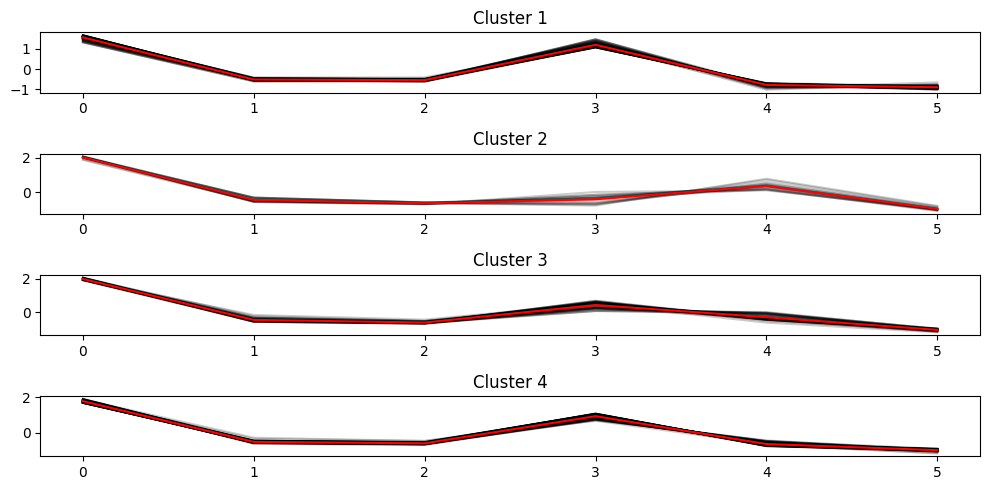

In [55]:
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt
import os
import warnings
warnings.simplefilter("ignore", FutureWarning)

# Initialize lists to store features for clustering
all_features = []
all_healthy_participants = []

# Iterate over the file paths
start = 0
for r in (100, 200, 300, 400, 500, 600, 700, 784):
    file_path = os.path.join(pilot_data_root, "cleaned_data", f"batch_{start}_{r}.csv")

    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        continue

    # Get the list of healthy participant IDs
    # Extract healthy participants
    healthy_participants = df[df['study_group'] == 'healthy']['participant_id'].unique()
    if len(healthy_participants) == 0:
        print(f"No healthy participants found in {file_path}")
        continue

    all_healthy_participants.extend(healthy_participants)
    # print(f" Healthy Participants ID: {healthy_participants}")
    start = r

    # Calculate metrics and prepare data for clustering
    for pid in healthy_participants:
        data = df[df['participant_id'] == pid]
        blood_glucose_values = data['blood_glucose_value'].values

        if len(blood_glucose_values) == 0:
            continue
        mean_blood_glucose = np.mean(blood_glucose_values)
        std_dev = np.std(blood_glucose_values)
        cv_percent = (std_dev / mean_blood_glucose) * 100

        # Define thresholds for TIR, TAR, TBR
        low_threshold = 70
        high_threshold = 140

        tir_percent = np.sum((blood_glucose_values >= low_threshold) & (blood_glucose_values <= high_threshold)) / len(blood_glucose_values) * 100
        tar_percent = np.sum(blood_glucose_values > high_threshold) / len(blood_glucose_values) * 100
        tbr_percent = np.sum(blood_glucose_values < low_threshold) / len(blood_glucose_values) * 100

        # Append features for clustering
        all_features.append([mean_blood_glucose, std_dev, cv_percent, tir_percent, tar_percent, tbr_percent])

# Convert features to numpy array and normalize
all_features = np.array(all_features)
# Ensure that there are participants to cluster
if all_features.shape[0] == 0:
    print("No data available for clustering.")
    exit()
scaler = TimeSeriesScalerMeanVariance()
features_scaled = scaler.fit_transform(all_features)

# Define the number of clusters
n_clusters = 4  # Adjust the number of clusters as needed

# Perform K-Means clustering
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True, random_state=42)
labels = model.fit_predict(features_scaled)

# Print the cluster labels
cluster_labels = {all_healthy_participants[i]: labels[i] for i in range(len(labels))}
print(f"Cluster labels: {cluster_labels}")

# Plot the clustered participants
plt.figure(figsize=(10, 5))
for yi in range(n_clusters):
    plt.subplot(n_clusters, 1, yi + 1)
    for xx in features_scaled[labels == yi]:
        plt.plot(xx, "k-", alpha=0.2)
    plt.plot(model.cluster_centers_[yi], "r-")
    plt.title(f"Cluster {yi + 1}")
plt.tight_layout()
plt.show()

# Print the results for each participant
# for i, pid in enumerate(all_healthy_participants):
#     print(f"Participant `{pid}` Glucose Analysis:")
#     print(f"Mean Blood Glucose (MBG): {all_features[i][0]:.2f} mg/dL")
#     print(f"Glucose Variability (Standard Deviation): {all_features[i][1]:.2f} mg/dL")
#     print(f"Coefficient of Variation (CV%): {all_features[i][2]:.2f}%")
#     print(f"Time in Range (TIR): {all_features[i][3]:.2f}%")
#     print(f"Time Above Range (TAR): {all_features[i][4]:.2f}%")
#     print(f"Time Below Range (TBR): {all_features[i][5]:.2f}%")
#     print("\n")

0.522 --> 0.342 --> 0.342 --> 
0.212 --> 0.126 --> 0.124 --> 0.124 --> 0.124 --> 0.124 --> 0.124 --> 0.124 --> 0.124 --> 0.124 --> 0.123 --> 0.123 --> 0.122 --> 0.122 --> 0.122 --> 0.122 --> 0.122 --> 0.122 --> 0.122 --> 0.122 --> 
0.072 --> 0.064 --> 0.063 --> 0.063 --> 0.063 --> 
0.053 --> 0.041 --> 0.041 --> 0.040 --> 0.040 --> 0.040 --> 
0.037 --> 0.032 --> 0.031 --> 0.031 --> 0.031 --> 0.031 --> 0.030 --> 0.030 --> 0.030 --> 0.030 --> 0.030 --> 0.030 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 0.029 --> 
0.033 --> 0.025 --> 0.024 --> 0.024 --> 0.024 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 0.023 --> 
0.029 --> 0.023 --> 0.022 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 
0.022 --> 0.019 --> 0.018 --> 0.018 --> 0.018 --> 0.018 --> 0.018 --> 0.018 --> 0.018 --> 0.018 --> 0.018 --> 0.018 --> 0.018 --> 
0.020 --> 0.

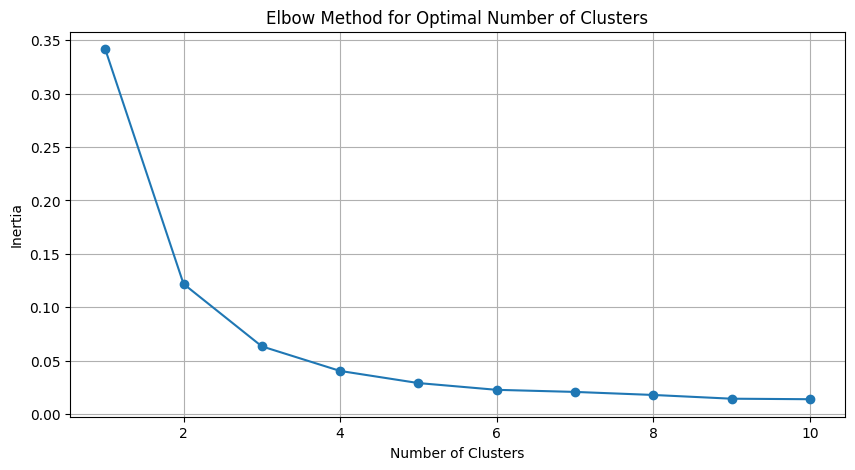

In [56]:
inertia = []

for i in range(1, 11):
    # Define the number of clusters
    n_clusters = i

    # Perform K-Means clustering
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", verbose=True, random_state=42)
    model.fit(features_scaled)
    
    # Append the inertia (sum of squared distances) to the list
    inertia.append(model.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

After 4 clusters, the inertia values decrease at a much slower rate, suggesting that the optimal number of clusters is likely around 3 or 4.

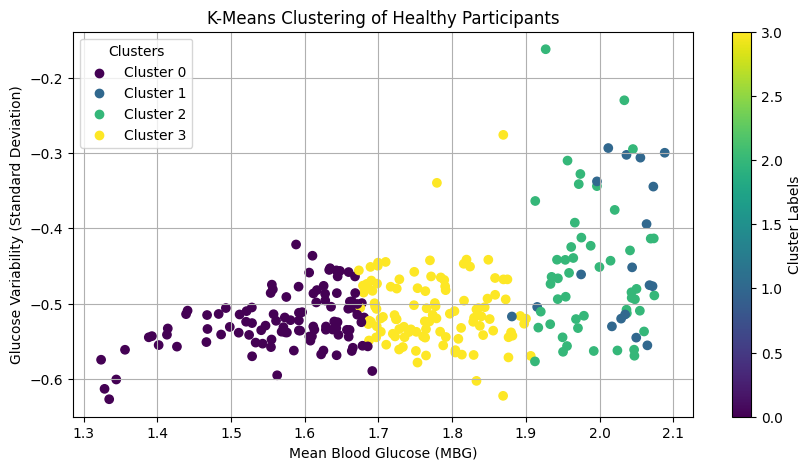

In [57]:
# mean_blood_glucose, std_dev, cv_percent, tir_percent, tar_percent, tbr_percent
# scatter plot graph for the features_sclaed data
plt.figure(figsize=(10, 5))
scatter = plt.scatter(features_scaled[:, 0], features_scaled[:, 1], c=labels, cmap='viridis')
plt.title('K-Means Clustering of Healthy Participants')
plt.xlabel('Mean Blood Glucose (MBG)')
plt.ylabel('Glucose Variability (Standard Deviation)')
plt.grid(True)

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Labels')
# Add a legend for the clusters
unique_labels = np.unique(labels)
for label in unique_labels:
    plt.scatter([], [], color=plt.cm.viridis(label / max(unique_labels)), label=f'Cluster {label}')
plt.legend(title="Clusters")
plt.show()


In [58]:
np.where(labels == 0)

(array([  3,   7,   8,  12,  15,  21,  25,  26,  30,  31,  35,  37,  38,
         40,  41,  43,  46,  47,  50,  55,  57,  62,  64,  67,  68,  69,
         72,  77,  80,  83,  85,  87,  94,  95,  99, 105, 107, 108, 109,
        116, 124, 130, 131, 135, 138, 139, 145, 150, 151, 152, 153, 158,
        162, 168, 169, 170, 172, 174, 175, 176, 177, 178, 179, 180, 181,
        183, 184, 186, 187, 192, 193, 195, 198, 199, 202, 203, 205, 209,
        210, 211, 225, 227, 228, 231, 232, 235, 236, 237, 242, 244, 247,
        249, 250, 251, 252, 253, 254, 260, 261, 263, 267, 273, 276, 280,
        281]),)

In [59]:
import pandas as pd
import numpy as np

# Extract the indices of participants in cluster 0
cluster_0_indices = np.where(labels == 0)[0]

# Define the column names for the features
columns = ['Mean Blood Glucose', 'Standard Deviation', 'Coefficient of Variation', 
		   'Time in Range (%)', 'Time Above Range (%)', 'Time Below Range (%)']

# Extract the features for cluster 3
cluster_3_features = all_features[cluster_0_indices]

# Convert the features to a DataFrame for easier analysis
cluster_3_df = pd.DataFrame(cluster_3_features.squeeze(), columns=columns)

# Calculate descriptive statistics for cluster 3
cluster_3_analysis = cluster_3_df.describe()

# Add range (max - min) to the analysis
cluster_3_analysis.loc['range'] = cluster_3_analysis.loc['max'] - cluster_3_analysis.loc['min']

# Print the analysis
print("Detailed Analysis of Cluster 3 Features:")
display(cluster_3_analysis)


Detailed Analysis of Cluster 3 Features:


,Mean Blood Glucose,Standard Deviation,Coefficient of Variation,Time in Range (%),Time Above Range (%),Time Below Range (%)
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,108.773647,17.771699,16.372595,92.790770,6.129004,1.080226
std,7.381678,3.386127,3.146629,3.124971,3.180317,2.137837
min,84.474743,8.906440,9.061575,83.816651,0.000000,0.000000
25%,105.587465,15.502060,14.400532,90.130964,3.648269,0.046773
50%,110.551918,17.483664,16.065428,92.797007,6.220767,0.280636
75%,113.850327,20.232622,18.361679,95.042095,8.793265,1.028999
max,121.123948,27.128842,27.228689,98.830683,11.973807,12.628625
range,36.649205,18.222401,18.167114,15.014032,11.973807,12.628625


In [60]:
# Print the cluster labels
print("AI-READI Healthy Participants : ", len(all_healthy_participants))
# Clusters with value 3 are considered as healthy participants
true_healthy = {all_healthy_participants[i]: labels[i] for i in range(len(labels)) if labels[i] == 0}
print(f"True Healthy labels: {true_healthy}")
print("True healthy participants len : ", len(true_healthy))
print("Percentage of true healthy participants over AI-READI Healthy : ", len(true_healthy) / len(all_healthy_participants) * 100, "%")

AI-READI Healthy Participants :  283
True Healthy labels: {np.int64(1033): np.int64(0), np.int64(1050): np.int64(0), np.int64(1051): np.int64(0), np.int64(1057): np.int64(0), np.int64(1069): np.int64(0), np.int64(1089): np.int64(0), np.int64(1109): np.int64(0), np.int64(1114): np.int64(0), np.int64(1120): np.int64(0), np.int64(1121): np.int64(0), np.int64(1132): np.int64(0), np.int64(1135): np.int64(0), np.int64(1136): np.int64(0), np.int64(1141): np.int64(0), np.int64(1145): np.int64(0), np.int64(1159): np.int64(0), np.int64(1164): np.int64(0), np.int64(1166): np.int64(0), np.int64(1178): np.int64(0), np.int64(1189): np.int64(0), np.int64(1199): np.int64(0), np.int64(1220): np.int64(0), np.int64(1225): np.int64(0), np.int64(1233): np.int64(0), np.int64(1235): np.int64(0), np.int64(1236): np.int64(0), np.int64(1242): np.int64(0), np.int64(1260): np.int64(0), np.int64(1266): np.int64(0), np.int64(1270): np.int64(0), np.int64(1272): np.int64(0), np.int64(1280): np.int64(0), np.int64(1294

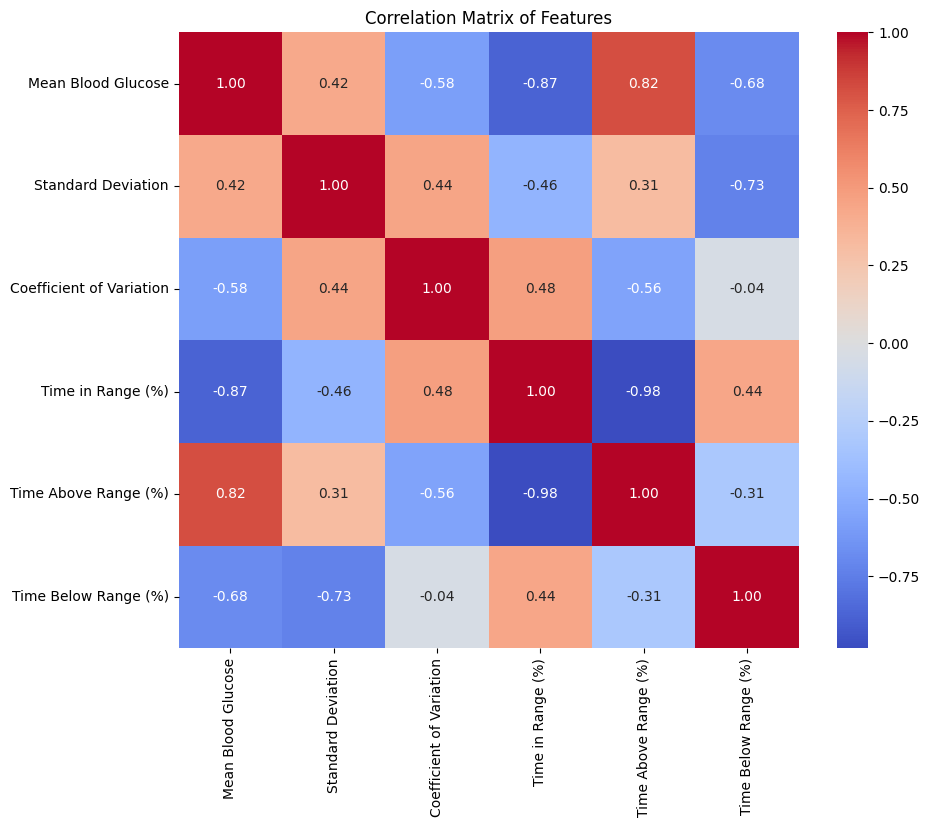

In [61]:
import pandas as pd
import seaborn as sns

# Convert features_scaled to a DataFrame
columns = ['Mean Blood Glucose', 'Standard Deviation', 'Coefficient of Variation', 
           'Time in Range (%)', 'Time Above Range (%)', 'Time Below Range (%)']
features_df = pd.DataFrame(features_scaled.squeeze(), columns=columns)

# Compute the correlation matrix
correlation_matrix = features_df.corr()

# Optionally, visualize the correlation matrix using a heatmap
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features')
plt.show()

**After manually checking through all the clusters of 0, it is verified that Cluster 0 is the True Healthy**